In [289]:
# OLG FOR MASTER THESIS (2022, Uni-Bonn)
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

np.set_printoptions(suppress=True)

#results = pd.read_excel(r'/Users/ojx/Desktop/Tasks/Data for MS/Pycharm/my_results.xlsx')

######Aggregate Data for each country [Uzbekistan, Tajikistan, Kyrgyzstan] in 2020######
########################################################################################

#Demographics
population_2020 = [34.2, 9.53, 6.58]      #World Bank, in millions
population_share =[0.68, 0.19, 0.13]      #World Bank, in %/100
pop_growth_2020 = [0.019,0.023, 0.019]    #World Bank, in %/100
life_exp_2020 =   [71.8, 71.3, 71.8]      #World Bank, average life expectancy of each country
retire_2020 =     [57.75, 60.5, 60.5]     #tradingeconomics, in real average mandatory retirement age of men and women
working_age_2020 =[22.7, 5.67, 4.3]       #ILO and World Bank, 15-64 working age population in millions
int_migrants_2020 =[3, 2.26, 1.0]         #Migrant Refugees and UN international migration, migrants in millions

#Fiscal and Economy
gdp_2021  =        [69.24, 8.74, 8.54]    #World Bank in $ billion
gdp_share =        [0.80,  0.101, 0.099]  #World Bank in %/100
remittance_share = [0.133,  0.327, 0.334] #World Bank in % of GDP
social_tax_2020 =  [0.12, 0.26, 0.2725]   #taxsummaries-pwc in %/100

#Total share of migrants and remittance
agg_migr_share= np.sum(int_migrants_2020)/np.sum(working_age_2020) #regional total migrants as a share of working age population 
agg_rem_share = np.matmul(remittance_share, gdp_share) #regional total remittance as a share of total regional gdp        

# Data importing from stata
dta_dist_of_age_eff     = pd.read_stata('/Users/ojx/Desktop/Tasks/Data for MS/calibration/final_calibration/A_age_efficiency.dta')
dta_dist_of_migrants    = pd.read_stata('/Users/ojx/Desktop/Tasks/Data for MS/calibration/final_calibration/A_dist_migrants.dta')
dta_dist_of_rem_send    = pd.read_stata('/Users/ojx/Desktop/Tasks/Data for MS/calibration/final_calibration/A_dist_rem_send.dta')
dta_dist_of_rem_recieve = pd.read_stata('/Users/ojx/Desktop/Tasks/Data for MS/calibration/final_calibration/A_dist_rem_receive.dta')

#Adjusting to python as an array
eff_low = np.array(dta_dist_of_age_eff['low_edu'])               # age efficiency profile of low type agents
eff_high = np.array(dta_dist_of_age_eff['high_edu'])             # age efficiency profile of high type agents

dist_migrant_low = np.array(dta_dist_of_migrants['dist_low_immig'])   #distribution of low type migrants by age
dist_migrant_high = np.array(dta_dist_of_migrants['dist_high_immig']) #distribution of high type migrants by age

remit_low_reciever  = np.array(dta_dist_of_rem_recieve['ma_rem_low'])     #distribution of low type agents receiving remittance by age
remit_high_reciever = np.array(dta_dist_of_rem_recieve['ma_rem_high'])    #distribution of high type agents receiving remittance by age

remit_low_sender    = np.array(dta_dist_of_rem_send['dist_rem_low'])      #distribution of low type agents sending remittance by age
remit_high_sender   = np.array(dta_dist_of_rem_send['dist_rem_high'])     #distribution of high type agents sending remittance by age

remit_high_share = np.array(dta_dist_of_rem_send['agg_rem_high_share'])   #total share of remittance send by high type
remit_low_share  = np.array(dta_dist_of_rem_send['agg_rem_low_share'])    #total share of remittance send by low type

rem_high_share = np.mean(remit_high_share)
rem_low_share = np.mean(remit_low_share)

###################### Model Parameters ################################################
########################################################################################

# Demographics
J  = round(np.matmul(life_exp_2020, population_share) - 20)   #life-span, regional avarage weighted by population
JR = round(np.matmul(retire_2020,  population_share)  - 20)   #age of retirement, regional avarage weighted by population
tR = J-JR+1   #length of retirement
tW = JR-1     #length of working life
n = np.matmul(pop_growth_2020, population_share) # Weighted average of population growth

# Parameters 
beta = 0.94  #discount factor: calibration inside the model
sigma = 2     #coefficient of relative risk: Kitao
gamma = 0.63  #weight on consumption: calibration inside the model
alpha = 0.4   #production elasticities of capital: Kjetil
delta = 0.048  #rate of depreciation: Kjetil
theta = 0.18   #literacy rate of those who hold college degree, calibrated outside the model, LIK
tau = np.matmul(social_tax_2020, gdp_share)    #average social security rate weighted by gdp

# Share of population by age and skills
mass = np.ones(J)
for i in range(1, len(mass)):
    mass[i] = mass[i-1]/(1+n)
mass = mass/sum(mass)
mass_low = (1-theta)*mass
mass_high = theta*mass

# Distribution of migrants by age and skills as of total regional population
migrants_low =  dist_migrant_low*agg_migr_share
migrants_high = dist_migrant_high*agg_migr_share

# Capital grids
kap = np.arange(0.01, 5, 0.01) #capital grids

# Storing features of model for each 14 scenarios
S_1 = 11  # number of different cases in scenario 1
S_2 = 5   # number of differenc cases in scenario 2
efficiency1  =  np.zeros((S_1,6)) #Aggregate variables for 14 scenarios
equity1      =  np.zeros((S_1,6)) #Inequality coefficients for 14 scenarios, ...
prices1      =  np.zeros((S_1,3)) #Factor prices of the model for each 14 scenarios, ...
remit1       =  np.zeros((S_1,5)) #Remittances for each 14 scenarios, ...

efficiency2  =  np.zeros((S_2,6)) #Aggregate variables for 14 scenarios
equity2      =  np.zeros((S_2,6)) #Inequality coefficients for 14 scenarios, ...
prices2      =  np.zeros((S_2,3)) #Factor prices of the model for each 14 scenarios, ...
remit2       =  np.zeros((S_2,5)) #Remittances for each 14 scenarios, ...

# ... first 11 as no refrom to full reform on everybody, last 12 and 13 scenarios are discouraging only high and low type and last is contrafactual

store_k_low  =  np.zeros((J,14)) #capital evolution for low type
store_k_high =  np.zeros((J,14))  #capital evolution for high type
store_c_low  =  np.zeros((J,14))  #consumption evolution for low type
store_c_high =  np.zeros((J,14))  #consumption evolution for high type
store_l_low  =  np.zeros((tW,14))  #labor hours for low type
store_l_high =  np.zeros((tW,14))  #labor hours for high type

income_retired_low = np.zeros((1,14))
income_retired_high = np.zeros((1,14))

Y = 1 # just a guess of output 
K0 = 1.538
L0 = 0.40
######################## Reforms taking place ###################################
#################################################################################
for scenarios in range(0,14):
    
    if scenarios<11: # meaning when no reform (0), up to 100% (10) reform with an increment of 10% in each scenario +1
        mass_low[0:(len(migrants_low))]= mass_low[0:(len(migrants_low))] - migrants_low*((scenarios)*0.1)
        mass_high[0:(len(migrants_high))]= mass_high[0:(len(migrants_high))] - migrants_high*((scenarios)*0.1)
        rem_low_dist = remit_low_reciever - remit_low_reciever*((10-scenarios)*0.1)
        rem_high_dist = remit_high_reciever - remit_high_reciever*((10-scenarios)*0.1)
         
    elif scenarios==11: # if only high type is discouraged
        mass_low[0:(len(migrants_low))]= mass_low[0:(len(migrants_low))] - migrants_low
        rem_low_dist =  remit_low_reciever  * rem_low_share 
        rem_high_dist = remit_high_reciever * rem_low_share

    elif scenarios==12: # if only low type is discouraged
        mass_high[0:(len(migrants_high))]= mass_high[0:(len(migrants_high))] - migrants_high
        rem_high_dist = remit_high_reciever * rem_high_share 
        rem_low_dist =  remit_low_reciever  * rem_high_share
    
    elif scenarios==13: # Check on contrafactual that current baseline doesnt have remittance but just migrants
        mass_low[0:(len(migrants_low))]= mass_low[0:(len(migrants_low))] - migrants_low
        mass_high[0:(len(migrants_high))]= mass_high[0:(len(migrants_high))] - migrants_high
        rem_low_dist = remit_low_reciever - remit_low_reciever
        rem_high_dist = remit_high_reciever - remit_high_reciever
        #If there was a migration but they dont send remittance
    
    q = 0
    neg = -1e10
    print("Scenario:", scenarios)
    while q<15:
        q = q + 1
        
        r0 = alpha*(K0**(alpha-1))*(L0**(1-alpha)) - delta    #rate of return on savings inside model
        w0 = (1-alpha)*(K0**(alpha))*(L0**(-alpha))           #equilibrium wage
        b  = tau*L0*w0/sum(mass[JR:])                         #pension benefits
        rem_low =  (rem_low_dist[0:len(mass_low)]*agg_rem_share*Y)/mass_low    #remittances received by each age for low type
        rem_high = (rem_high_dist[0:len(mass_high)]*agg_rem_share*Y)/mass_high  #remittances received by each age for high type
        
        ###### Backward Induction ######

        # Storage
        v_low       = np.zeros((len(kap), J)) #indirect utility of low type
        v_high      = np.zeros((len(kap), J)) #indirect utility of high type
        kapopt_low  = np.ones((len(kap), J))  #position of optimal capital choice in an array
        kapopt_high = np.ones((len(kap), J))  #position of optimal capital choice in an array
        labopt_low  = np.ones((len(kap), tW)) #position of optimal labor choice in an array
        labopt_high  = np.ones((len(kap), tW)) #position of optimal labor choice in an array

        ### Retired Households

        # Last period
        last_cons_low  = (1+r0)*kap + b + rem_low[J-1]
        last_cons_high = (1+r0)*kap + b + rem_high[J-1]
        util_low       = (last_cons_low**(gamma*(1-sigma)))/(1-sigma)
        util_high      = (last_cons_high**(gamma*(1-sigma)))/(1-sigma)
        v_low  [:,J-1]   = util_low
        v_high [:,J-1]   = util_high

        for j in range(J-2,tW-1,-1):
            for ik0 in range(0,(len(kap))):

                # Low type
                vmin_low  = neg
                ik1=0

                while ik1<(len(kap)):
                    kap0 = kap[ik0]
                    kap1 = kap[ik1]

                    cons_low  = (1+r0)*kap0 + b - kap1 + rem_low[j]

                    if cons_low <=0:
                        util_low = neg
                    else:
                        util_low = ((cons_low**((1-sigma)*gamma))-1)/(1-sigma)

                    v0_low = util_low + beta*v_low[ik1, j+1]

                    if v0_low>vmin_low:
                        v_low[ik0,j] = v0_low
                        kapopt_low[ik0,j] = ik1
                        vmin_low = v0_low
                    else:
                        break
                    ik1  = ik1+1

                # High Type
                vmin_high = neg
                ik1 = 0
                while ik1<(len(kap)):
                    kap0 = kap[ik0]
                    kap1 = kap[ik1]

                    cons_high = (1+r0)*kap0 + b - kap1 + rem_high[j]

                    if cons_high<=0:
                        util_high = neg
                    else:
                        util_high = ((cons_high**((1-sigma)*gamma))-1)/(1-sigma)

                    v0_high = util_high + beta*v_high[ik1, j+1]

                    if v0_high>vmin_high:
                        v_high[ik0,j] = v0_high
                        kapopt_high[ik0,j] = ik1
                        vmin_high = v0_high
                    else:
                        break
                    ik1  = ik1+1

        ### Working Households
        
        for j in range(tW-1,-1,-1):
            for ik0 in range(0, len(kap)):

                # Low type
                vmin_low = neg
                ik1 = 0

                while ik1<len(kap):

                    kap0 = kap[ik0]
                    kap1 = kap[ik1]

                    lab_low = (gamma*(1-tau)*eff_low[j]*w0-(1-gamma)*((1+r0)*kap0 - kap1+rem_low[j]))/((1-tau)*eff_low[j]*w0)
                    if lab_low>1:
                        lab_low=1
                    elif lab_low<0:
                        lab_low=0

                    cons_low = (1+r0)*kap0 + (1-tau)*w0*eff_low[j]*lab_low - kap1 + rem_low[j]

                    if cons_low <=0:
                        util_low = neg
                    else:
                        util_low = ((((cons_low**gamma)*(1-lab_low)**(1-gamma))**(1-sigma))-1)/(1-sigma)

                    v0_low = util_low + beta*v_low[ik1,j+1]

                    if v0_low>vmin_low:
                        v_low[ik0,j]= v0_low
                        kapopt_low[ik0,j] = ik1
                        labopt_low[ik0,j] = lab_low
                        vmin_low = v0_low
                    else:
                        break

                    ik1 = ik1+1

                # High type
                vmin_high = neg
                ik1 = 0

                while ik1<len(kap):

                    kap0 = kap[ik0]
                    kap1 = kap[ik1]

                    lab_high = (gamma*(1-tau)*eff_high[j]*w0-(1-gamma)*((1+r0)*kap0 - kap1+rem_high[j]))/((1-tau)*eff_high[j]*w0)
                    if lab_high>1:
                        lab_high=1
                    elif lab_high<0:
                        lab_high=0

                    cons_high = (1+r0)*kap0 + (1-tau)*w0*eff_high[j]*lab_high - kap1 + rem_high[j]

                    if cons_high <=0:
                        util_high = neg
                    else:
                        util_high = ((((cons_high**gamma)*(1-lab_high)**(1-gamma))**(1-sigma))-1)/(1-sigma)

                    v0_high = util_high + beta*v_high[ik1,j+1]

                    if v0_high>vmin_high:
                        v_high[ik0,j]= v0_high
                        kapopt_high[ik0,j] = ik1
                        labopt_high[ik0,j] = lab_high
                        vmin_high = v0_high
                    else:
                        break
                    ik1 = ik1+1

        ### Aggregate capital stock and employment

        # Low type
        kgen_low = np.zeros(J)
        labgen_low = np.zeros(tW)
        consume_low = np.zeros(J)

        #generating optimal responses of agents by backward induction
        ik0 = 0
        for j in range(0, J-1):
            ik1 = kapopt_low[ik0, j]
            ik1 = int(ik1)
            kgen_low[j] = kap[ik1]

            if j<= tW-1:
                labgen_low[j] = labopt_low[ik0,j]
            ik0 = ik1

        for i in range(0,J):
            if i<tW-1:
                consume_low[i] = (1+r0)*kgen_low[i] + (1-tau)*w0*eff_low[i]*labgen_low[i] - kgen_low[i+1] + rem_low[i]
            elif i==J-1:
                consume_low[i] = (1+r0)*kgen_low[i] + b  + rem_low[i]
            else:
                consume_low[i] = (1+r0)*kgen_low[i] + b - kgen_low[i+1] + rem_low[i]
        C_low = np.matmul(consume_low, mass_low)
        K1_low = np.matmul(kgen_low,mass_low)
        L1_low = np.matmul(np.multiply(labgen_low, eff_low[0:len(labgen_low)]), mass_low[0:tW])

        # High type
        kgen_high = np.zeros(J)
        labgen_high = np.zeros(tW)
        consume_high = np.zeros(J)

        ik0 = 0
        for j in range(0, J-1):
            ik1 = kapopt_high[ik0, j]
            ik1 = int(ik1)
            kgen_high[j] = kap[ik1]

            if j<= tW-1:
                labgen_high[j] = labopt_high[ik0,j]
            ik0 = ik1

        for i in range(0,J):
            if i<tW-1:
                consume_high[i] = (1+r0)*kgen_high[i] + (1-tau)*w0*eff_high[i]*labgen_high[i] - kgen_high[i+1] + rem_high[i]
            elif i==J-1:
                consume_high[i] = (1+r0)*kgen_high[i] + b  + rem_high[i]
            else:
                consume_high[i] = (1+r0)*kgen_high[i] + b - kgen_high[i+1] + rem_high[i]
        cons_low_util = sum(consume_low)
        cons_high_util = sum(consume_high)

        K1_high = np.matmul(kgen_high,mass_high)
        L1_high = np.matmul((np.multiply(labgen_high, eff_high[0:len(labgen_high)])), mass_high[0:tW])
        C_high = np.matmul(consume_high, mass_high)

        # Update K0 and L0
        K0 = 0.9*K0 + 0.1*(K1_low + K1_high)
        L0 = 0.9*L0 + 0.1*(L1_low + L1_high)
        Y = (K0**alpha)*(L0**(1-alpha))
    
    h_low = np.matmul(labgen_low, mass_low[0:len(labgen_low)])/sum(mass_low[0:len(labgen_low)])  
    h_high = np.matmul(labgen_high, mass_high[0:len(labgen_high)])/sum(mass_high[0:len(labgen_high)])     
    
    t_low  = sum(rem_low)
    t_high = sum(rem_high)
    T = (np.matmul(rem_high,mass_high[0:len(rem_high)]))+(np.matmul(rem_low,mass_low[0:len(rem_low)]))
    mass_low = (1-theta)*mass
    mass_high = theta*mass
    
    #Storing all the aggregate variables across scenarios
    if scenarios<11:
        store_k_low[:,10-scenarios] = kgen_low
        store_k_high[:,10-scenarios] = kgen_high
        store_c_low[:, 10-scenarios] = consume_low
        store_c_high[:,10- scenarios] = consume_high
        store_l_low[:, 10-scenarios] = labgen_low
        store_l_high[:, 10-scenarios] = labgen_high
        income_retired_low  [:,10-scenarios]= tR*b + sum(rem_low[JR-1:J])
        income_retired_low  [:,10-scenarios]= tR*b + sum(rem_high[JR-1:J])
    else:
        store_k_low[:,scenarios] = kgen_low
        store_k_high[:,scenarios] = kgen_high
        store_c_low[:, scenarios] = consume_low
        store_c_high[:, scenarios] = consume_high
        store_l_low[:, scenarios] = labgen_low
        store_l_high[:, scenarios] = labgen_high
        income_retired_low  [:,scenarios]= tR*b + sum(rem_low[JR-1:J])
        income_retired_low  [:,scenarios]= tR*b + sum(rem_high[JR-1:J])

    if scenarios<11:
        efficiency1[10-scenarios, :] = [K0, L0, K0/Y, Y, C_low, C_high]
        equity1[10-scenarios, :]     = [cons_low_util, cons_high_util, cons_high_util/cons_low_util, v0_low, v0_high,  v0_low/v0_high]   
        prices1[10-scenarios, :]     = [r0, w0, b]
        remit1 [10-scenarios, :]     = [T, t_low, t_high, h_low, h_high]
    elif scenarios>10 and scenarios<13:
        efficiency2[scenarios-10, :] = [K0, L0, K0/Y, Y, C_low, C_high]
        equity2[scenarios-10, :]     = [cons_low_util, cons_high_util, cons_high_util/cons_low_util, v0_low, v0_high,  v0_low/v0_high]   
        prices2[scenarios-10, :]     = [r0, w0, b]
        remit2 [scenarios-10, :]     = [T, t_low, t_high, h_low, h_high]
    else:
        efficiency2[scenarios-9, :] = [K0, L0, K0/Y, Y, C_low, C_high]
        equity2[scenarios-9, :]     = [cons_low_util, cons_high_util, cons_high_util/cons_low_util, v0_low, v0_high,  v0_low/v0_high]   
        prices2[scenarios-9, :]     = [r0, w0, b]
        remit2 [scenarios-9, :]     = [T, t_low, t_high, h_low, h_high]
        
    if scenarios==0:
        efficiency2[3, :] = [K0, L0, K0/Y, Y, C_low, C_high]
        equity2    [3, :]     = [cons_low_util, cons_high_util, cons_high_util/cons_low_util, v0_low, v0_high,  v0_low/v0_high]   
        prices2    [3, :]     = [r0, w0, b]
        remit2     [3, :]     = [T, t_low, t_high, h_low, h_high]
    elif scenarios==10:
        efficiency2[0, :] = [K0, L0, K0/Y, Y, C_low, C_high]
        equity2    [0, :]     = [cons_low_util, cons_high_util, cons_high_util/cons_low_util, v0_low, v0_high,  v0_low/v0_high]   
        prices2    [0, :]     = [r0, w0, b]
        remit2     [0, :]     = [T, t_low, t_high, h_low, h_high]

results_efficiency1 = pd.DataFrame(efficiency1, columns=['K0', 'L0', 'K0/Y', 'Y', 'C_low', 'C_high'], index=['0% - no reform', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100% - full reform'])
results_equity1     = pd.DataFrame(equity1, columns=['c_l', 'c_h', 'ineq', 'v0_l', 'v0_h', 'utility_ineq'], index=['0% - no reform', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100% - full reform'])
results_prices1     = pd.DataFrame(prices1, columns=['r0', 'w0', 'b'], index=['0% - no reform', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100% - full reform'])
results_remit1      = pd.DataFrame(remit1, columns=['T', 't_low', 't_high', 'h_l', 'h_h'], index=['0% - no reform', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100% - full reform'])

results_efficiency2 = pd.DataFrame(efficiency2, columns=['K0', 'L0', 'K0/Y', 'Y', 'C_low', 'C_high'], index=['0% - no reform', 'only high return', 'only low return', '100% - full reform', 'countrafactual-no rem'])
results_equity2     = pd.DataFrame(equity2, columns=['c_l', 'c_h', 'ineq', 'v0_l', 'v0_h', 'utility_ineq'], index=['0% - no reform',  'only high return', 'only low return', '100% - full reform', 'countrafactual-no rem'])
results_prices2     = pd.DataFrame(prices2, columns=['r0', 'w0', 'b'],  index=['0% - no reform',  'only high return', 'only low return', '100% - full reform', 'countrafactual-no rem'])
results_remit2      = pd.DataFrame(remit2, columns=['T', 't_low', 't_high', 'h_l', 'h_h'], index=['0% - no reform',  'only high return', 'only low return', '100% - full reform', 'countrafactual-no rem'])

results_efficiency1.to_excel("Results/results_efficiency1.xlsx")
results_equity1.to_excel("Results/results_equity1.xlsx")
results_prices1.to_excel("Results/results_prices1.xlsx")
results_remit1.to_excel("Results/results_remit1.xlsx")

results_efficiency2.to_excel("Results/results_efficiency2.xlsx")
results_equity2.to_excel("Results/results_equity2.xlsx")
results_prices2.to_excel("Results/results_prices2.xlsx")
results_remit2.to_excel("Results/results_remit2.xlsx")

capital_low  = np.zeros((1,14))
capital_high = np.zeros((1,14))
cons_low     = np.zeros((1,14))
cons_high    = np.zeros((1,14))

for i in range(0,14):
    capital_low [0,i] = sum(store_k_low[:,i])
    capital_high[0,i] = sum(store_k_high[:,i])
    cons_low[0,i]     = sum(store_c_low[:,i])
    cons_high[0,i]    = sum(store_c_high[:,i])
    
print('Done')

Scenario: 0
Scenario: 1
Scenario: 2
Scenario: 3
Scenario: 4
Scenario: 5
Scenario: 6
Scenario: 7
Scenario: 8
Scenario: 9
Scenario: 10
Scenario: 11
Scenario: 12
Scenario: 13
Done


[[43.03556422 42.71574724 42.44454655 42.0997197  41.83771932 41.53108299
  41.16287326 40.87977275 40.55756529 40.16598672 39.67479832 43.17887417
  39.85763788 38.08097973]]


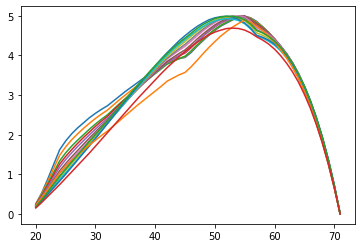

In [295]:
plt.plot(age[0:len(store_k_high)], store_k_high)
capital_low  = np.zeros((1,14))
capital_high = np.zeros((1,14))
cons_low     = np.zeros((1,14))
cons_high    = np.zeros((1,14))

for i in range(0,14):
    capital_low [0,i] = sum(store_k_low[:,i])
    capital_high[0,i] = sum(store_k_high[:,i])
    cons_low[0,i]     = sum(store_c_low[:,i])
    cons_high[0,i]    = sum(store_c_high[:,i])
print(results_efficiency1)


In [296]:
from IPython.display import display
import pandas as pd
import numpy as np
from pandas.plotting import table

  
table_a = {'no reform (0%)' : efficiency1[0,[0,1,3,2]],
          '10%' : efficiency1[1,[0,1,3,2]],
          '20%' : efficiency1[2,[0,1,3,2]],
          '...' : ['...', '...', '...', '...'],
          '80%' : efficiency1[8,[0,1,3,2]],
          '90%' : efficiency1[9,[0,1,3,2]],
          '100%' : efficiency1[10,[0,1,3,2]],
          'total change':['-->', '-->', '-->', '-->'],
          'in %': (100*(efficiency1[10,[0,1,3,2]]-efficiency1[0,[0,1,3,2]])/efficiency1[0,[0,1,3,2]])
          #'        ':['        ','   ','   ', '   '],
          #'high-skilled': (100*(results[[0,1,12,16],11]-results[[0,1,12,16],10])/results[[0,1,12,16],10]),
          #'low-skilled':  (100*(results[[0,1,12,16],12]-results[[0,1,12,16],10])/results[[0,1,12,16],10])
          }

table_efficiency1 = pd.DataFrame(table_a, index=['Capital', 'Labor', 'Output', 'Capital/Output'])
  
# displaying the DataFrame          
display(table_efficiency1.round(3))


,no reform (0%),10%,20%,...,80%,90%,100%,total change,in %
Capital,1.966,2.000,2.039,...,2.289,2.327,2.308,-->,17.370
Labor,0.327,0.340,0.353,...,0.435,0.446,0.446,-->,36.491
Output,0.670,0.690,0.712,...,0.845,0.864,0.861,-->,28.495
Capital/Output,2.935,2.897,2.865,...,2.709,2.693,2.681,-->,-8.658


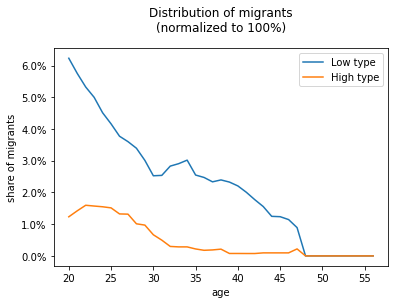

In [129]:
import matplotlib.ticker as mtick
age = range(20,70)
dist_migrant_low = dist_migrant_low
plt.plot(age[0:len(dist_migrant_low)], dist_migrant_low, label="Low type")
plt.plot(age[0:len(dist_migrant_high)], dist_migrant_high, label="High type")
plt.legend()
plt.title("Distribution of migrants" +"\n"+ "(normalized to 100%)", y=1.05)
plt.xlabel('age')
plt.ylabel('share of migrants')
plt.plot()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig('figures/figure_1.png', bbox_inches='tight')


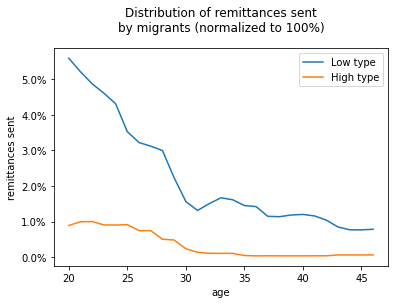

In [130]:
import matplotlib.ticker as mtick
age = range(20,70)
plt.plot(age[0:len(remit_low_sender)], remit_low_sender, label="Low type")
plt.plot(age[0:len(remit_high_sender)], remit_high_sender, label="High type")
plt.legend()
plt.title("Distribution of remittances sent" + "\n" + "by migrants (normalized to 100%)", y=1.05)
plt.xlabel('age')
plt.ylabel('remittances sent')
plt.plot()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig('figures/figure_2.png', bbox_inches='tight')

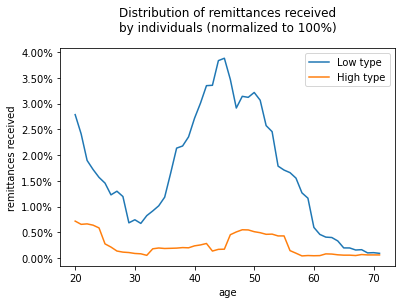

In [138]:
import matplotlib.ticker as mtick
age = range(20,90)
plt.plot(age[0:J], remit_low_reciever[0:J], label="Low type")
plt.plot(age[0:J], remit_high_reciever[0:J], label="High type")
plt.legend()
plt.title("Distribution of remittances received" + "\n" + "by individuals (normalized to 100%)", y=1.05)
plt.xlabel('age')
plt.ylabel('remittances received')
plt.plot()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig('figures/figure_3.png', bbox_inches='tight')

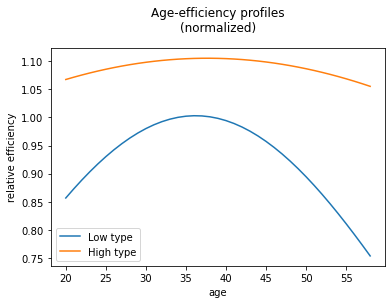

In [151]:
import matplotlib.ticker as mtick
age = range(20,90)
plt.plot(age[0:JR], eff_low[0:JR], label="Low type")
plt.plot(age[0:JR], eff_high[0:JR], label="High type")
plt.legend()
plt.title("Age-efficiency profiles" + "\n" + "(normalized)", y=1.05)
plt.xlabel('age')
plt.ylabel('relative efficiency')
plt.plot()
plt.savefig('figures/figure_4.png', bbox_inches='tight')